# Querying datasets

In [182]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
import symphony_data as sd
import tqdm

import sys
sys.path.append('../dj_modules/')
import dj_metadata as djm
import dj_populate as djp

import pandas as pd
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp

import importlib
import seaborn as sns

In [183]:
dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
dj.conn()

DataJoint connection (disconnected) root@127.0.0.1:3306

In [16]:
djm.load_metadata(str_metadata_dir='/Volumes/data-1/data/metadata/json/')

20241121C
20250121C
Added 2 new experiments


In [17]:
djp.load_chunks_and_files()
djp.load_typing()
djp.load_typing_notes('/Users/riekelabbackup/Downloads/SortedData - Sheet1.csv')

20230825C not in Experiment table.
20230825C not in Experiment table.
20230825C not in Experiment table.
20240606H not in Experiment table.
20240611H not in Experiment table.
20240611H not in Experiment table.
20240627H not in Experiment table.
20240627H not in Experiment table.
20240717H not in Experiment table.
20240717H not in Experiment table.
20240717H not in Experiment table.
20241121H not in Experiment table.
20241121H not in Experiment table.
20241121H not in Experiment table.
Added 10 new data files
Error: 2 space delimiter resulted in (800,) shape
Error: 2 space delimiter resulted in (2,) shape
Error: 2 space delimiter resulted in (486,) shape
Error: 2 space delimiter resulted in (592,) shape
Error: 2 space delimiter resulted in (6,) shape
Error: 2 space delimiter resulted in (529,) shape
There are 196 entries in CellTyping table


List of common protocols:
- manookinlab.protocols.MovingChromaticBar
- manookinlab.protocols.DovesMovie
- manookinlab.protocols.GratingDSOS
- manookinlab.protocols.ObjectMotionDots
- manookinlab.protocols.SparseNoise
- manookinlab.protocols.ChirpStimulus

In [171]:
import tqdm
importlib.reload(djm)
ls_protocols = ['manookinlab.protocols.MovingChromaticBar', 'manookinlab.protocols.DovesMovie', 
                'manookinlab.protocols.GratingDSOS', 'manookinlab.protocols.ObjectMotionDots', 
                'manookinlab.protocols.SparseNoise', 'manookinlab.protocols.ChirpStimulus']

quality_order = ['Gorgeous', 'High', 'Medium', 'Low', 'Empty']
d_plot = {'protocol': [], 'quality': [], 'n_datasets': []}
for str_protocol in tqdm.tqdm(ls_protocols):
    df_meta = djm.meta_from_protocol([str_protocol])
    df_meta = df_meta.reset_index()
    df_meta['dataset'] = df_meta['date_id'] + '_' + df_meta['chunk_id']

    df_ct = djm.celltyping_from_meta(df_meta)
    df_ct['dataset'] = df_ct['date_id'] + '_' + df_ct['chunk_id']

    
    # Group by date_id and find the best quality label for each date_id
    df_ct['quality_rank'] = df_ct['quality'].apply(lambda x: quality_order.index(x))
    df_best_quality = df_ct.loc[df_ct.groupby('date_id')['quality_rank'].idxmin()]
    
    # srs_cts = df_ct['quality'].value_counts()
    srs_cts = df_best_quality['quality'].value_counts()
    str_protocol = str_protocol.split('.')[-1]
    for str_quality, n_datasets in srs_cts.items():
        d_plot['protocol'].append(str_protocol)
        d_plot['quality'].append(str_quality)
        d_plot['n_datasets'].append(n_datasets)
    # Also append n_no_ct_date attribute of df_ct
    d_plot['protocol'].append(str_protocol)
    d_plot['quality'].append('Untyped')
    d_plot['n_datasets'].append(df_ct.n_no_ct_date)

  0%|          | 0/6 [00:00<?, ?it/s]

No cell typing for 49 chunks
No cell typing for 24 dates


 33%|███▎      | 2/6 [00:01<00:03,  1.28it/s]

No cell typing for 20 chunks
No cell typing for 10 dates
No cell typing for 32 chunks
No cell typing for 22 dates


 50%|█████     | 3/6 [00:02<00:02,  1.21it/s]

No cell typing for 37 chunks
No cell typing for 21 dates


 67%|██████▋   | 4/6 [00:03<00:01,  1.15it/s]

No cell typing for 31 chunks
No cell typing for 14 dates


 83%|████████▎ | 5/6 [00:04<00:00,  1.12it/s]

No cell typing for 39 chunks
No cell typing for 16 dates


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


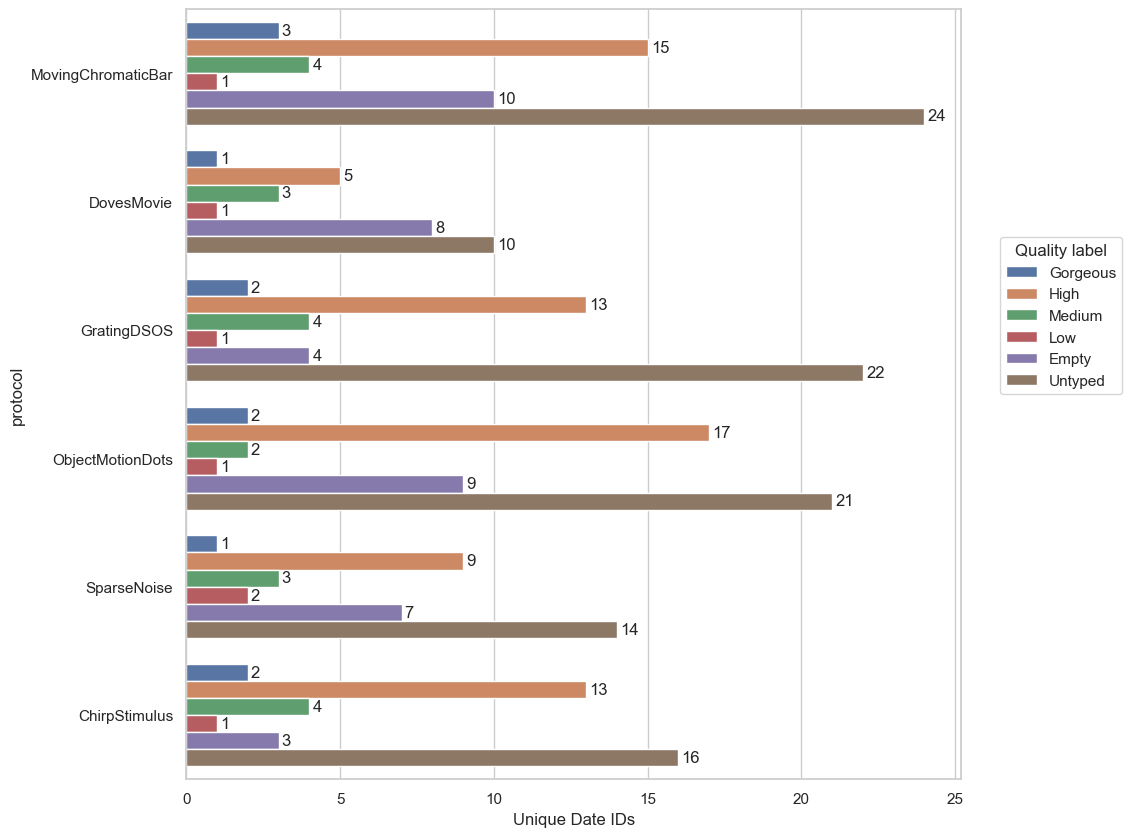

In [173]:
df_plot = pd.DataFrame(d_plot)
f, ax = plt.subplots(figsize=(10,10))
barplot = sns.barplot(data=df_plot, y='protocol', x='n_datasets', hue='quality', 
            hue_order=['Gorgeous', 'High', 'Medium', 'Low', 'Empty', 'Untyped'], ax=ax)
ax.legend(loc=(1.05, 0.5), title='Quality label')
ax.set_xlabel('Unique Date IDs')
# Print value to the right of the bar
# Add text to the right of each bar
for p in barplot.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{int(width)}', 
            ha='left', va='center')
            

## Mosaics

In [135]:

df_plot = pd.melt(df_ct, id_vars=['dataset', 'typing_file', 'quality'], value_vars=['num_on_p', 'num_off_p', 'num_on_m', 'num_off_m', 'num_sbc'],
        var_name='cell_type')
df_plot = df_plot.sort_values(by='dataset')

In [136]:
df_plot = df_plot.sort_values(by='quality', key=lambda x: x.map({'Gorgeous': 0, 'High': 1, 'Medium': 2, 'Low': 3, np.nan: 4}))

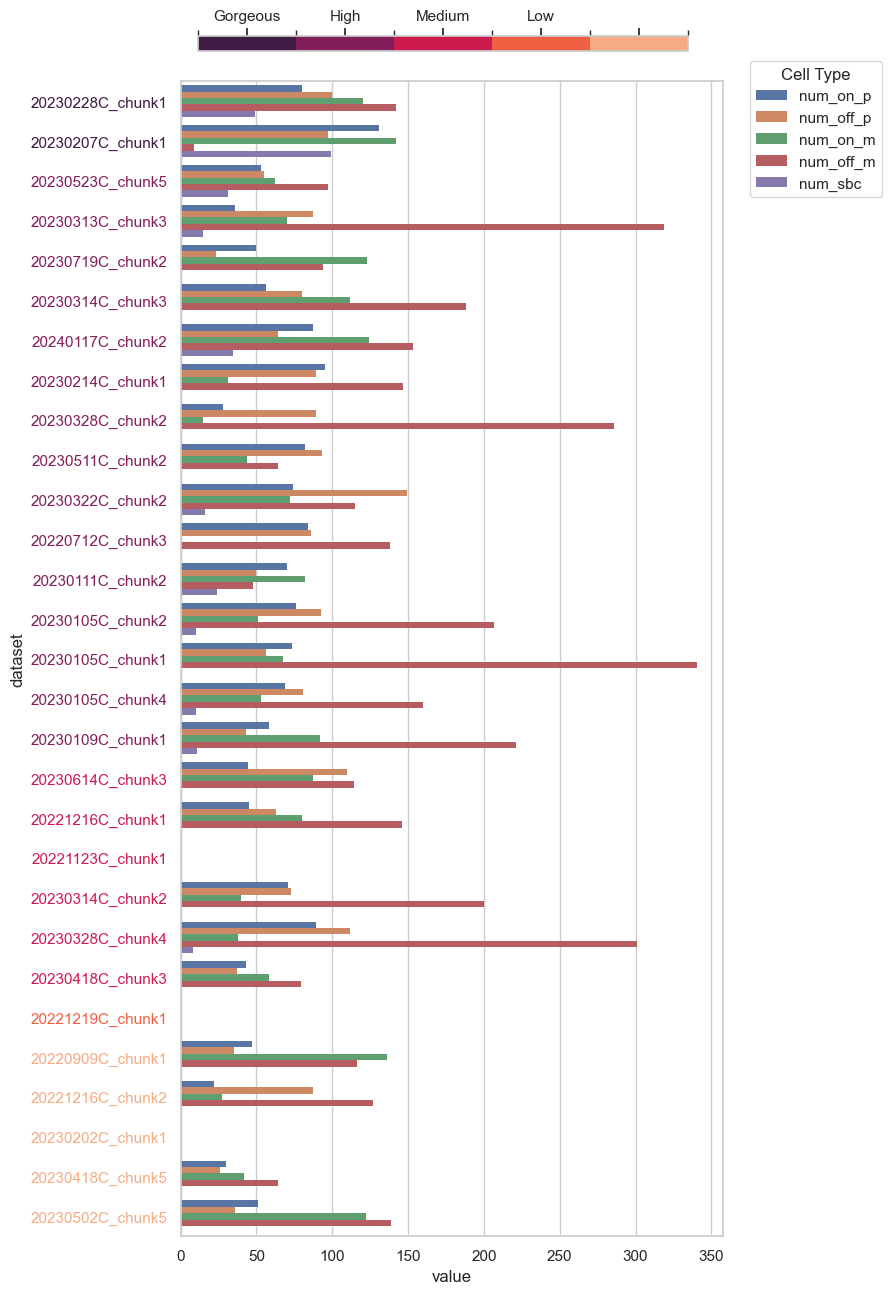

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
f, ax = plt.subplots(figsize=(7, 15))
sns.set_theme('notebook', 'whitegrid')
sns.barplot(data=df_plot, y='dataset', x='value', hue='cell_type', 
            hue_order=['num_on_p', 'num_off_p', 'num_on_m', 'num_off_m', 'num_sbc'],
            edgecolor='none', width=0.8, errorbar=None, ax=ax)
ax.legend(loc=(1.05, 0.9), title='Cell Type')
# Color yticks by quality
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
unique_qualities = df_plot['quality'].unique()
quality_colors = sns.color_palette('rocket', len(unique_qualities))
d_colors = {quality: color for quality, color in zip(unique_qualities, quality_colors)}
for i, ytick in enumerate(yticks):
    yticklabel = yticklabels[i]
    dataset = yticklabel.get_text()
    quality = df_plot[df_plot['dataset'] == dataset]['quality'].values[0]
    yticklabel.set_color(d_colors[quality])

# Categorical colorbar for quality
# Create a categorical colorbar for quality
cmap = mcolors.ListedColormap(quality_colors)
bounds = range(len(unique_qualities) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Add the colorbar above the axis
cbar_ax = f.add_axes([0.15, 0.9, 0.7, 0.01])  # [left, bottom, width, height]
cbar = mcolorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal', ticks=bounds)
cbar.set_ticks([i + 0.5 for i in range(len(unique_qualities))])
cbar.set_ticklabels(unique_qualities)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax.set_xlabel('Number of Cells')

Loading 20230228C chunk1 /Volumes/data-1/analysis/20230228C/chunk1/kilosort2/kilosort2.classification.txt
Loading STA from /Volumes/data-1/analysis/20230228C/chunk1/kilosort2/kilosort2.params...
Loaded STA for 800 cells.
Loading 20230207C chunk1 /Volumes/data-1/analysis/20230207C/chunk1/kilosort2/kilosort2.classification_fmr.txt
Loading STA from /Volumes/data-1/analysis/20230207C/chunk1/kilosort2/kilosort2.params...
Loaded STA for 910 cells.
Loading 20230207C chunk1 /Volumes/data-1/analysis/20230207C/chunk1/kilosort2/kilosort2.classification.txt
Loading STA from /Volumes/data-1/analysis/20230207C/chunk1/kilosort2/kilosort2.params...
Loaded STA for 910 cells.
Loading 20230111C chunk2 /Volumes/data-1/analysis/20230111C/chunk2/kilosort2/kilosort2.classification_fmr.txt
Loading STA from /Volumes/data-1/analysis/20230111C/chunk2/kilosort2/kilosort2.params...
Loaded STA for 971 cells.
Loading 20230111C chunk2 /Volumes/data-1/analysis/20230111C/chunk2/kilosort2/kilosort2.classification_fmr_sa

FileNotFoundError: /Volumes/data-1/analysis/20220712C/chunk3/kilosort2/corrupt_kilosort2.classification.txt not found.

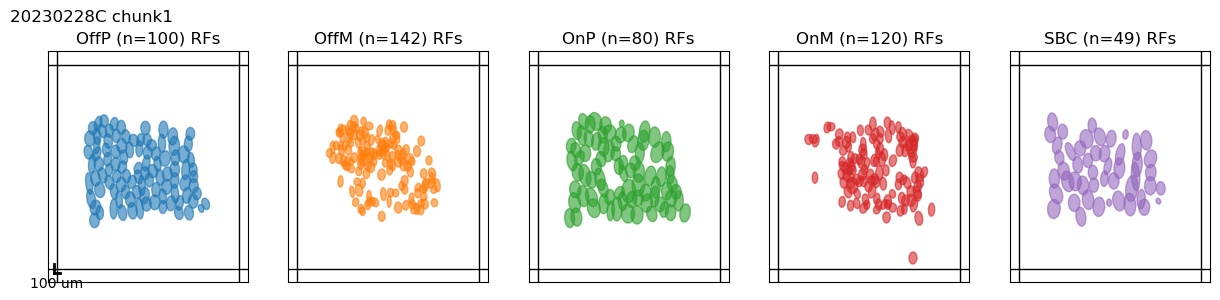

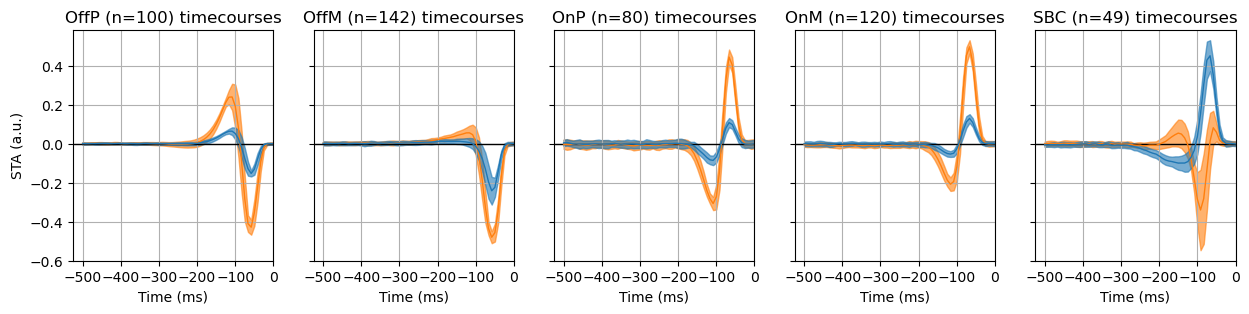

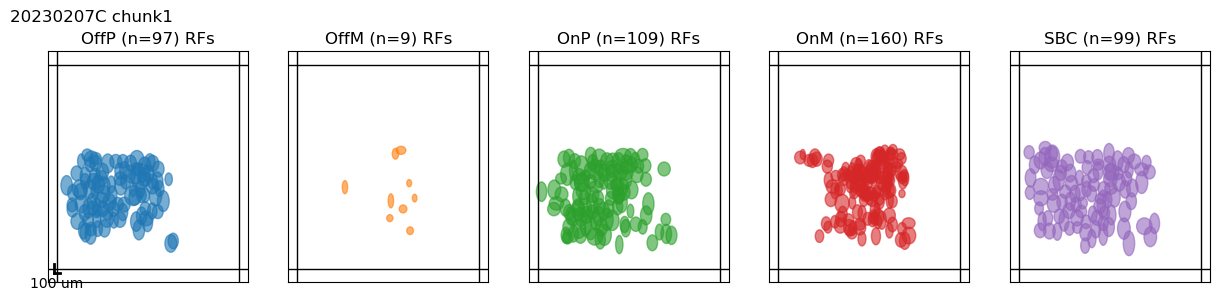

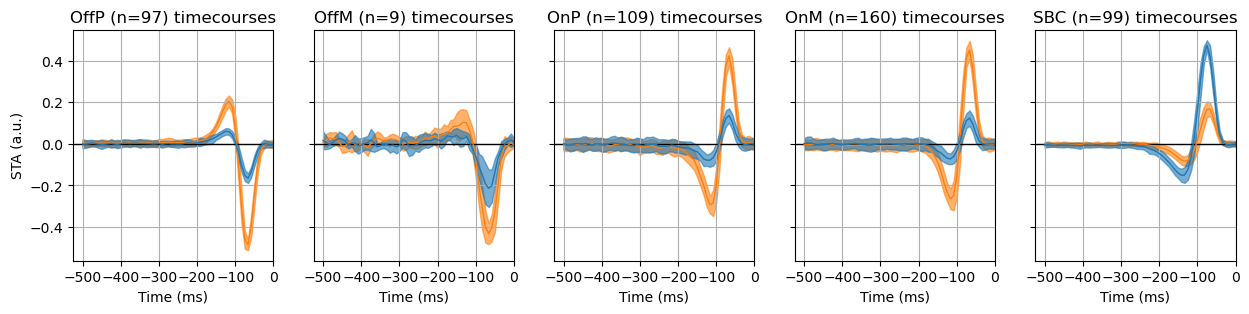

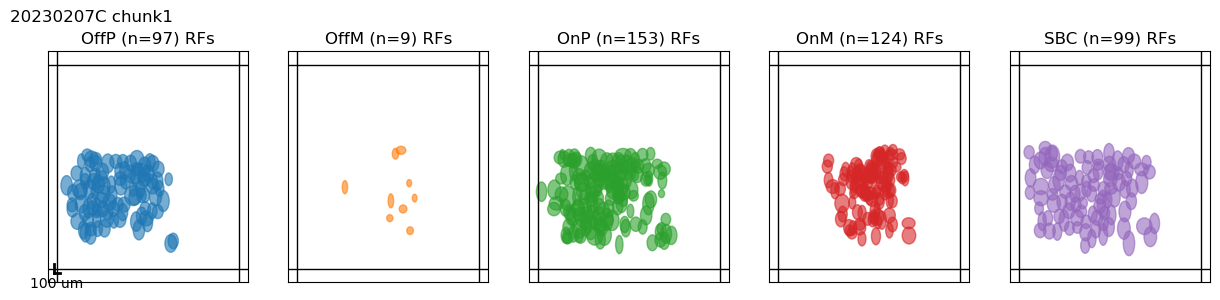

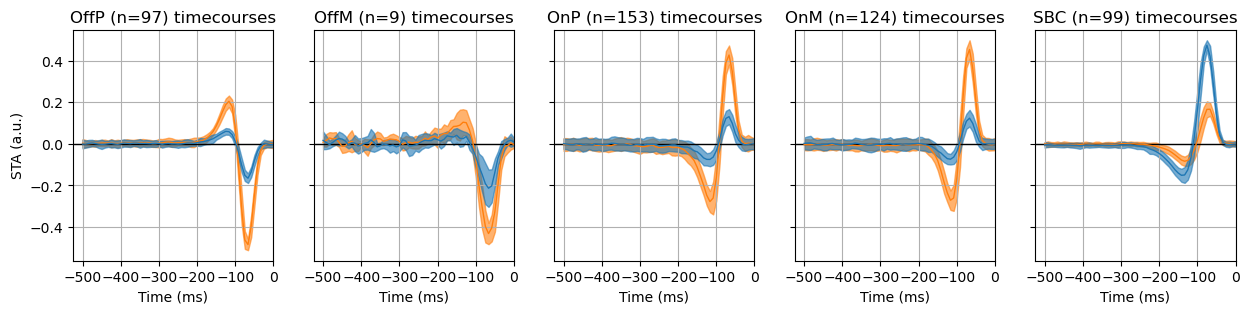

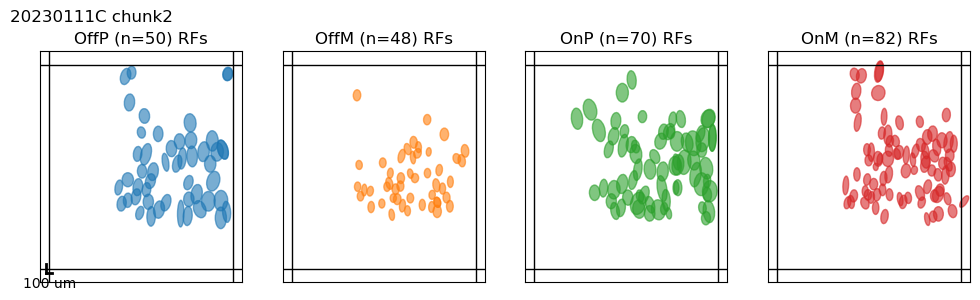

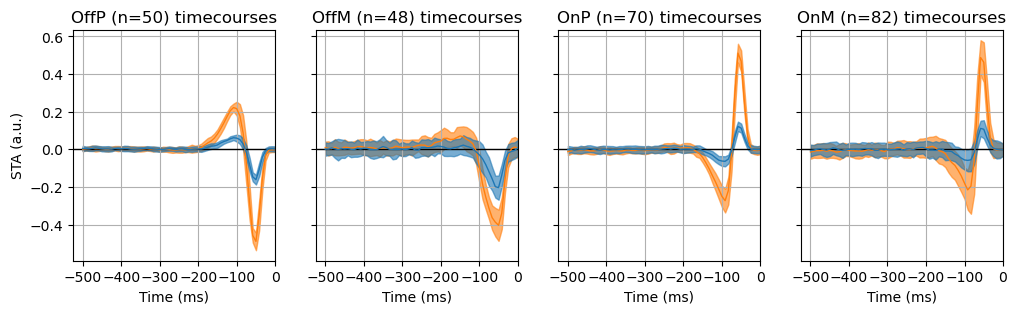

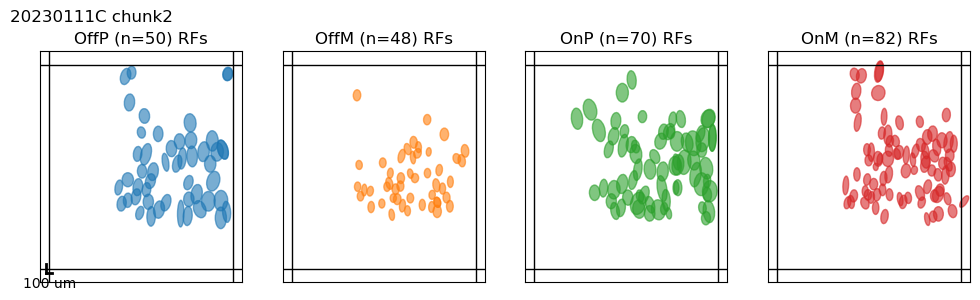

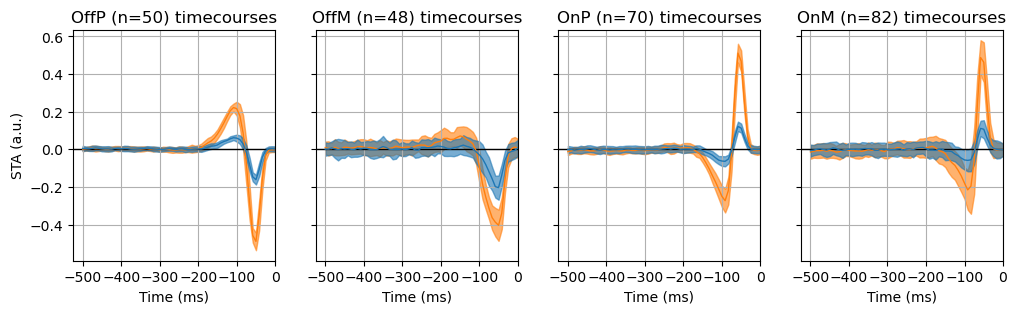

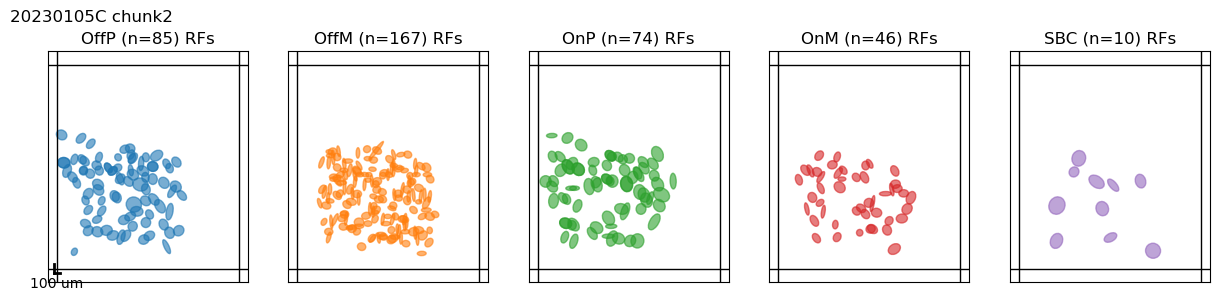

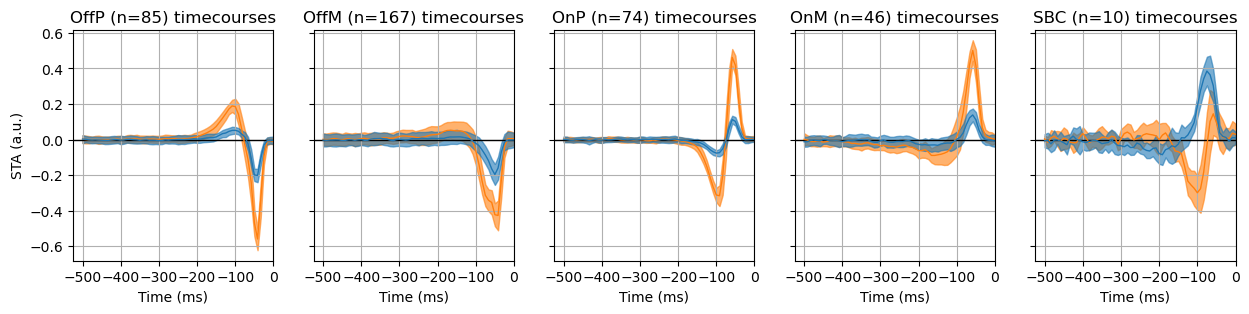

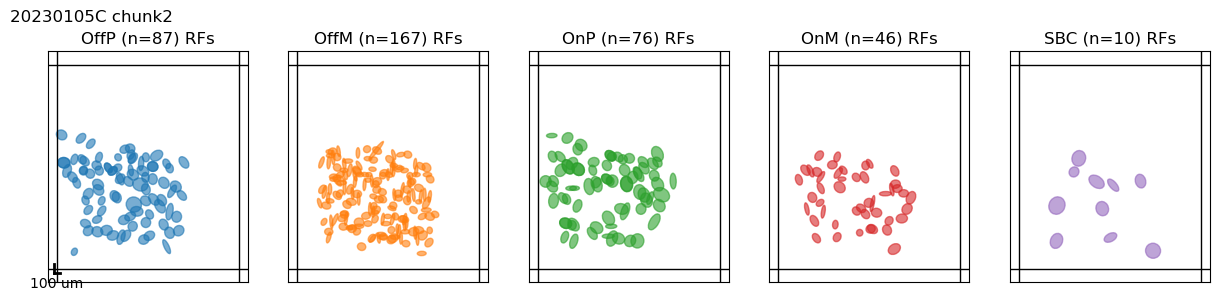

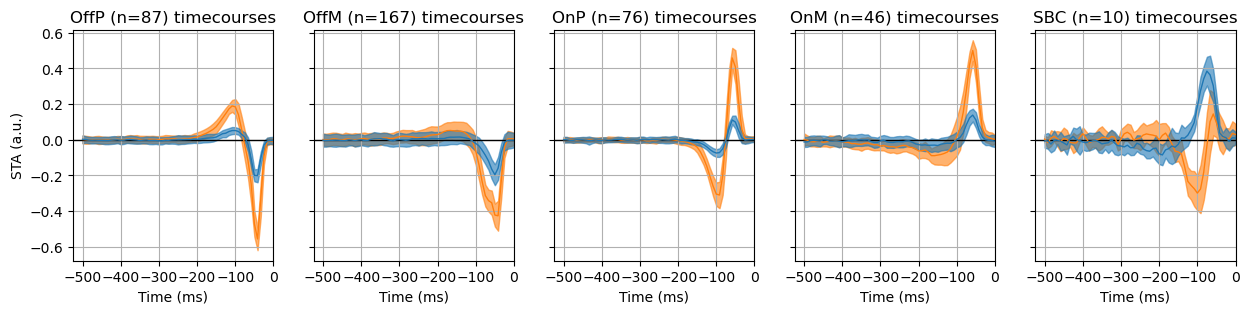

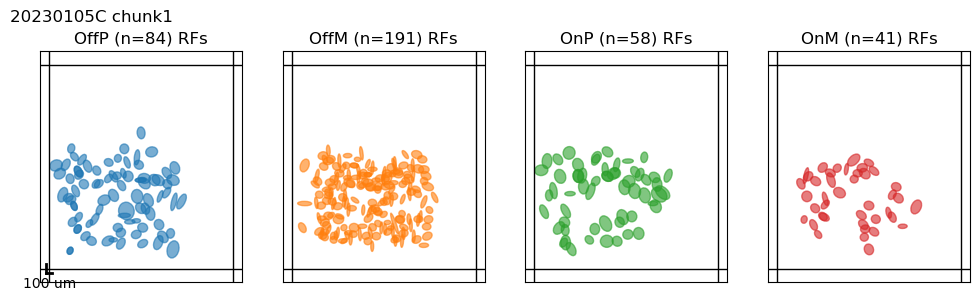

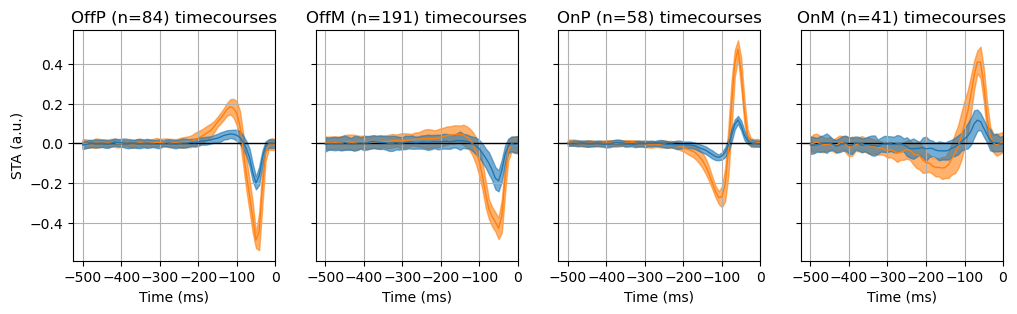

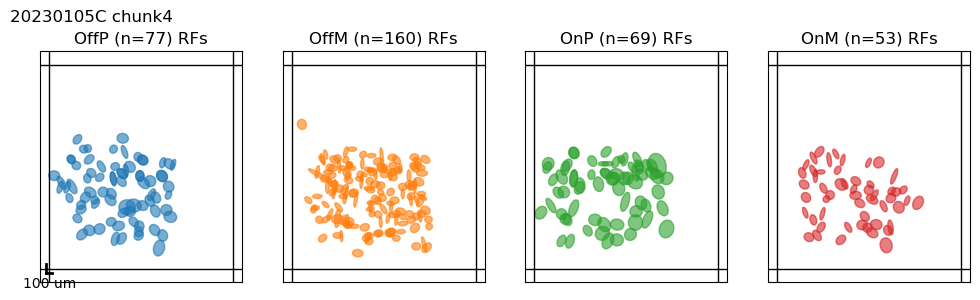

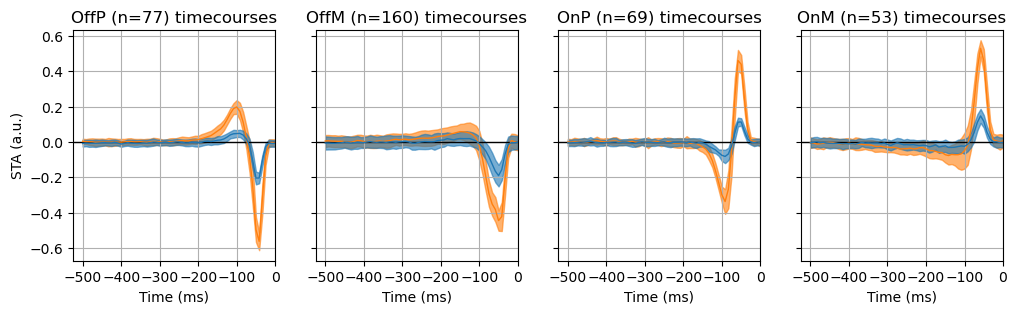

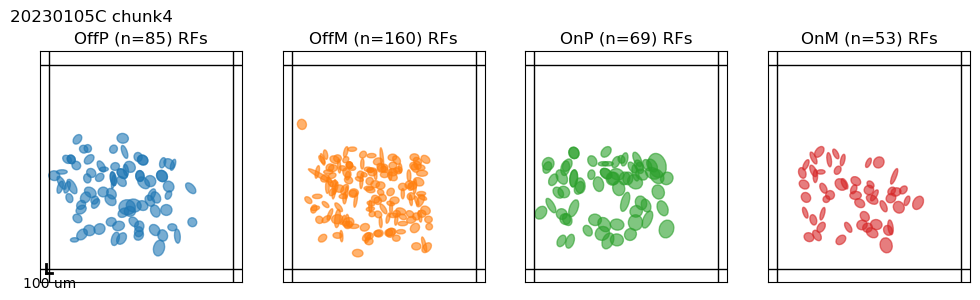

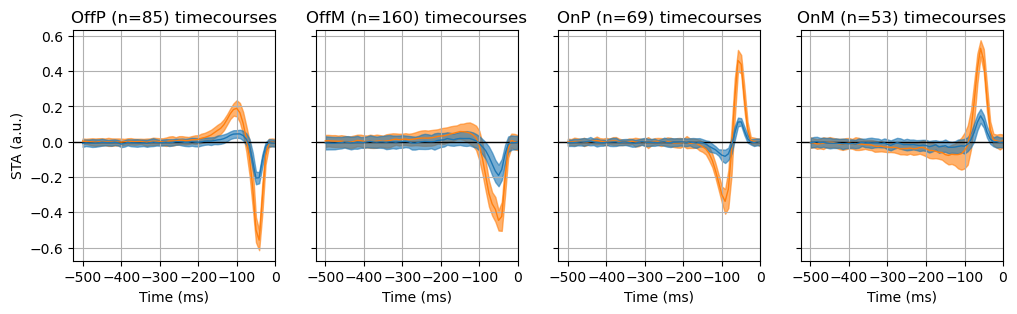

In [ ]:
importlib.reload(sp)
def plot_cell_types(df_ct, algo='kilosort2'):
    # Move multiindex to columns
    df_ct = df_ct.reset_index()

    # Sort df_ct by quality, with Gorgeous first, then High, Medium, Low, then empty
    df_ct = df_ct.sort_values(by='quality', key=lambda x: x.map({'Gorgeous': 0, 'High': 1, 'Medium': 2, 'Low': 3, np.nan: 4}))

    
    # Iterate through all date_id and chunk_id in df_ct
    df_ct = df_ct[df_ct['algorithm']==algo]

    dates = df_ct['date_id'].unique()
    for date_id in dates:
        chunks = df_ct[df_ct['date_id']==date_id]['chunk_id'].unique()

        for chunk_id in chunks:
            typing_files = df_ct[(df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id)]['typing_file'].unique()

            for idx_t, typing_file in enumerate(typing_files):
                # Get sum of num_on_p etc for each typing file
                mask = (df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id) & (df_ct['typing_file']==typing_file)
                n_cells = df_ct[mask].loc[:, 'num_on_p':'num_sbc'].values.sum()
                if n_cells==0:
                    print(f"ERROR: {typing_file} has no cell types corresponding to defined labels")
                else:
                    
                    d_paths =  {
                    "str_experiment": date_id,
                    
                    "dataset_name": algo,
                    "str_algo": algo,
                    # "str_chunk": chunk_id,
                    "str_classification": typing_file,
                    "str_protocol": "noise",
                    "paramsfile": f'/Volumes/data-1/analysis/{date_id}/{chunk_id}/{algo}/{algo}.params',
                    }

                    print(f'Loading {date_id} {chunk_id} {typing_file}')
                    try:
                        data = so.SpikeOutputs(**d_paths)
                        data.load_sta_from_params()
                        axs = sp.plot_type_rfs(data, sd_mult=0.8)
                        # Get figure handle and add text for date and chunk
                        f = axs[0].get_figure()
                        f.text(0.1, 0.98, f'{date_id} {chunk_id}', fontsize=12)
                        f.patch.set_facecolor('white')
                        axs = sp.plot_type_tcs(data)
                    except Exception as e:
                        print(f'ERROR: {date_id} {chunk_id} {typing_file}')
                        print(e)    
                    

plot_cell_types(df_ct)